# 02a-splicebert_embeddings-training_set_full.ipynb: Nucleotide embedding analysis for HBV and host splicing patterns (full Spliceator training set)
Extracts nucleotide embeddings, applies dimensionality reduction, and performs clustering to uncover splice site sequence patterns in both HBV and host genomes.

Generate HBV pgRNA consensus sequences from BAM files

In [ ]:
! cat ../data/processed_files/lib.txt | while read i j k l m; do \
    echo $i $j && \
    bcftools mpileup -Ou -f ../ref/pgrna/${j}/${j}.pgrna.fa \
    ../data/processed_files/$m/$i/Aligned.markdup.sorted.uniq.bam \
    | bcftools call --ploidy 1 -mv -Oz -o ../data/processed_files/$m/$i/calls.vcf.gz && \
    \
    bcftools norm -f ../ref/pgrna/${j}/${j}.pgrna.fa \
    ../data/processed_files/$m/$i/calls.vcf.gz -Ob -o ../data/processed_files/$m/$i/calls.norm.bcf && \
    \
    bcftools view -e 'QUAL <= 10 || DP > 35 || MQBZ < -3 || RPBZ < -3 || RPBZ > 3 || SCBZ > 3' \
    ../data/processed_files/$m/$i/calls.norm.bcf -Ob -o ../data/processed_files/$m/$i/calls.norm.flt.bcf && \
    \
    bcftools index ../data/processed_files/$m/$i/calls.norm.flt.bcf && \
    \
    cat ../ref/pgrna/${j}/${j}.pgrna.fa \
    | bcftools consensus ../data/processed_files/$m/$i/calls.norm.flt.bcf \
    > ../data/processed_files/$m/$i/consensus.fa; done 2>&1 | tee ../data/processed_files/consensus.log

# concatenate all consensus sequences
! for i in ../data/processed_files/*/*/consensus.fa; do \
    sra=`echo $(dirname $i) | sed 's|/|\t|' | cut -f2` && \
    awk -v s=$sra '{if(/>/) {print $i "_" s} else {print $i}}' $i; done > ../data/processed_files/consensus.fa

Extend consensus fasta sequences by adding flanking sequences to the upstream of PreC ORF and the downstream of X ORF

In [1]:
import sys
import os
import logging

scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))

if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
    
from common import fasta_to_dataframe

In [2]:
cons = fasta_to_dataframe("../data/processed_files/consensus.fa")
cons['seq'] = cons.seq.apply(lambda x: x.upper())
cons['seq'] = cons.seq.apply(lambda x: x[-280:-25] + x[:-25] + x[:510])
cons["tid"] = ">" + cons.tid
cons.to_csv("../data/processed_files/consensus_flank255_510.fa", 
            sep="\n", index=None, header=None)

Create BED files for splice donor and acceptor sites

In [3]:
sralib = pd.read_csv("../data/processed_files/lib.txt", sep="\t", header=None)
sradir = "../data/processed_files/"
sralib["gtf_path"] = sradir + sralib[4] + "/" + sralib[0] + "/stringtie.gtf2"
sralib["cons_path"] = sradir + sralib[4] + "/" + sralib[0] + "/consensus.fa"

In [4]:
# Find all GT sites

dfs = []

for f in sralib.cons_path.tolist():
    try:
        fa = fasta_to_dataframe(f)
        sraname = f.replace(sradir,"").replace("/consensus.fa","").split("/")[1]
        positions = []
        for i in range(fa.seq.apply(len)[0]):
            if fa.seq[0].upper()[i:i+2] == "GT":
                positions.append([fa.tid[0] + "_" + sraname, i, i+2, "GT", sraname, "+"])

        dfs.append(pd.DataFrame(positions))
    except Exception as e:
        logging.error(f"Couldn't read {f}: {e}")
        pass
    
dfs = pd.concat(dfs)
dfs.to_csv(sradir + "consensus_splice_donors.bed", sep="\t", header=None, index=None)

ERROR:root:Couldn't read ../data/processed_files/paired_end_100/SRR3140239/consensus.fa: No columns to parse from file
ERROR:root:Couldn't read ../data/processed_files/paired_end_100/SRR3140250/consensus.fa: [Errno 2] No such file or directory: '../data/processed_files/paired_end_100/SRR3140250/consensus.fa'
ERROR:root:Couldn't read ../data/processed_files/paired_end_100/SRR3140251/consensus.fa: [Errno 2] No such file or directory: '../data/processed_files/paired_end_100/SRR3140251/consensus.fa'


In [5]:
# Find all AG sites

dfs = []

for f in sralib.cons_path.tolist():
    try:
        fa = fasta_to_dataframe(f)
        sraname = f.replace(sradir,"").replace("/consensus.fa","").split("/")[1]
        positions = []
        for i in range(fa.seq.apply(len)[0]):
            if fa.seq[0].upper()[i:i+2] == "AG":
                positions.append([fa.tid[0] + "_" + sraname, i, i+2, "AG", sraname, "+"])

        dfs.append(pd.DataFrame(positions))
    except Exception as e:
        logging.error(f"Couldn't read {f}: {e}")
        pass
    
dfs = pd.concat(dfs)
dfs.to_csv(sradir + "consensus_splice_acceptors.bed", sep="\t", header=None, index=None)

ERROR:root:Couldn't read ../data/processed_files/paired_end_100/SRR3140239/consensus.fa: No columns to parse from file
ERROR:root:Couldn't read ../data/processed_files/paired_end_100/SRR3140250/consensus.fa: [Errno 2] No such file or directory: '../data/processed_files/paired_end_100/SRR3140250/consensus.fa'
ERROR:root:Couldn't read ../data/processed_files/paired_end_100/SRR3140251/consensus.fa: [Errno 2] No such file or directory: '../data/processed_files/paired_end_100/SRR3140251/consensus.fa'


Extract splice donor sites from SJ.out.tab files

In [ ]:
# concatenate SJ.out.tab
! for i in ../data/processed_files/*/*/SJ.out.tab; do \
    awk -v var=$i 'BEGIN{OFS="\t"} {print $1, $2-1, $3, $4, $5, $6, $7, $8, $9, var}' $i; done \
    | grep -v STARpass1 | sed 's|/|\t|g' | cut -f-9,11 > ../data/processed_files/sj.out.tab

# get splice donor sites
! awk 'BEGIN{OFS="\t"} $5==1 && $7>=5 {print $1 "_" $NF, $2, $2+2, $7, $NF, "+"}' ../data/processed_files/sj.out.tab \
    | awk '!/chr/' > ../data/processed_files/splice_donor_sj.bed

! bedtools intersect -a ../data/processed_files/consensus_splice_donors.bed -b ../data/processed_files/splice_donor_sj.bed -wo \
    | awk 'BEGIN{OFS="\t"} !seen[$0]++ {print $1,$2,$3,$4 "(donor)",$5,$6}' > ../data/processed_files/splice_donors.bed

! bedtools intersect \
    -a <(sed 's/_/\t/' ../data/processed_files/consensus_splice_donors.bed | awk 'BEGIN{OFS="\t"} !seen[$1,$3,$4,$5,$7]++ {print $1, $3, $4, $5, ".", $7}') \
    -b <(sed 's/_/\t/' ../data/processed_files/splice_donor_sj.bed | awk 'BEGIN{OFS="\t"} !seen[$1,$3,$4,$7]++ {print $1, $3, $4, ".", ".", $7}') -wo \
    | cut -f-6 | sort -k1,1 -k2,2n > ../data/processed_files/splice_donors_.bed

Liftover splice site positions to other genotypes

In [ ]:
# position mapping between genotypes
# https://mafft.cbrc.jp/alignment/software/addsequences.html
! for i in B2 C2 D3; do \
    mafft \
    --addfull ../ref/pgrna/${i}/${i}.pgrna.fa \
    --mapout ../ref/pgrna/A2/A2.pgrna.fa; done

In [6]:
# read in MAFFT mapout files
b2m = pd.read_csv("../ref/pgrna/B2/B2.pgrna.fa.map", sep=",", skiprows=1)
b2m.columns = ["base","B2_pos","A2_pos"]
b2m = b2m[["B2_pos","A2_pos"]]

c2m = pd.read_csv("../ref/pgrna/C2/C2.pgrna.fa.map", sep=",", skiprows=1)
c2m.columns = ["base","C2_pos","A2_pos"]
c2m = c2m[["C2_pos","A2_pos"]]

d3m = pd.read_csv("../ref/pgrna/D3/D3.pgrna.fa.map", sep=",", skiprows=1)
d3m.columns = ["base","D3_pos","A2_pos"]
d3m = d3m[["D3_pos","A2_pos"]]

hbvmap = pd.merge(pd.merge(b2m, c2m, how="outer"), d3m, how="outer")
d_ = pd.read_csv("../data/processed_files/splice_donors_.bed", sep="\t", header=None)

In [8]:
bts = []

for i in d_[0].unique():
    bt = pd.merge(d_[d_[0]==i].copy().rename(columns={1:i + "_pos"}), hbvmap[["A2_pos", i + "_pos"]]).drop(i + "_pos", axis=1)
    bt = pd.merge(bt.rename(columns={"A2_pos":"start", 2:i + "_pos"}), hbvmap[["A2_pos", i + "_pos"]]).drop(i + "_pos", axis=1)
    bt.rename(columns={"A2_pos":"end"}, inplace=True)
    bts.append(bt)

In [9]:
bts = pd.concat(bts)
bts[0] = "A2"
bts.columns = ["chr","name","score","strand","start","end"]
bts = pd.merge(bts.rename(columns={"start":"A2_pos"}), hbvmap)
bts.columns = ["chr","name","score","strand","A2_start","A2_pos","B2_start","C2_start","D3_start"]
bts = pd.merge(bts, hbvmap)

In [10]:
# liftover
donor_inferred = []

for i in hbvmap.columns:
    bt = bts[["chr", i.replace("pos","") + "start", i, "name", "score", "strand"]].copy()
    bt.columns = ["chr","start","end","name","score","strand"]
    bt["chr"] = i.replace("_pos","")
    donor_inferred.append(bt)
    
donor_inferred = pd.concat(donor_inferred)
donor_inferred.drop_duplicates(inplace=True)
donor_inferred["start"] = donor_inferred["start"].astype(int)
donor_inferred["end"] = donor_inferred["end"].astype(int)
donor_inferred["name"] = "GT(donor)"
donor_inferred.to_csv("../data/processed_files/splice_donors_inferred.bed", 
                      sep="\t", header=None, index=None)

In [ ]:
! bedtools intersect \
    -a <(sed 's/_/\t/' ../data/processed_files/consensus_splice_donors.bed | awk 'BEGIN{OFS="\t"} !seen[$1,$3,$4,$5,$7]++ {print $1, $3, $4, $5, $2, $7}') \
    -b ../data/processed_files/splice_donors_inferred.bed -wo \
    | awk 'BEGIN{OFS="\t"} {print $1 "_" $5,$2,$3,$4,$5,$6}' \
    | sort -u > ../data/processed_files/splice_donors_inferred.bed2

! mv ../data/processed_files/splice_donors_inferred.bed2 ../data/processed_files/splice_donors_inferred.bed

! cat ../data/processed_files/splice_donors_inferred.bed ../data/processed_files/consensus_splice_donors.bed | sort | uniq -c \
    | awk 'BEGIN{OFS="\t"} {if($1==1) {print $2, $3, $4, $5"(non-donor)", $6, $7} else {print $2, $3, $4, $5"(donor)", $6, $7}}' > ../data/processed_files/splice_donors.bed

Extract splice acceptor sites from SJ.out.tab files

In [ ]:
! awk 'BEGIN{OFS="\t"} $5==1 && $7>=5 {print $1 "_" $NF, $3-2, $3, $7, $NF, "+"}' ../data/processed_files/sj.out.tab \
    | awk '!/chr/' > ../data/processed_files/splice_acceptor_sj.bed

! bedtools intersect -a ../data/processed_files/consensus_splice_acceptors.bed -b ../data/processed_files/splice_acceptor_sj.bed -wo \
    | awk 'BEGIN{OFS="\t"} !seen[$0]++ {print $1,$2,$3,$4 "(acceptor)",$5,$6}' > ../data/processed_files/splice_acceptors.bed

! bedtools intersect \
    -a <(sed 's/_/\t/' ../data/processed_files/consensus_splice_acceptors.bed | awk 'BEGIN{OFS="\t"} !seen[$1,$3,$4,$5,$7]++ {print $1, $3, $4, $5, ".", $7}') \
    -b <(sed 's/_/\t/' ../data/processed_files/splice_acceptor_sj.bed | awk 'BEGIN{OFS="\t"} !seen[$1,$3,$4,$7]++ {print $1, $3, $4, ".", ".", $7}') -wo \
    | cut -f-6 | sort -k1,1 -k2,2n > ../data/processed_files/splice_acceptors_.bed

In [11]:
# read in MAFFT mapout files
b2m = pd.read_csv("../ref/pgrna/B2/B2.pgrna.fa.map", sep=",", skiprows=1)
b2m.columns = ["base","B2_pos","A2_pos"]
b2m = b2m[["B2_pos","A2_pos"]]

c2m = pd.read_csv("../ref/pgrna/C2/C2.pgrna.fa.map", sep=",", skiprows=1)
c2m.columns = ["base","C2_pos","A2_pos"]
c2m = c2m[["C2_pos","A2_pos"]]

d3m = pd.read_csv("../ref/pgrna/D3/D3.pgrna.fa.map", sep=",", skiprows=1)
d3m.columns = ["base","D3_pos","A2_pos"]
d3m = d3m[["D3_pos","A2_pos"]]

hbvmap = pd.merge(pd.merge(b2m, c2m, how="outer"), d3m, how="outer")
d_ = pd.read_csv("../data/processed_files/splice_acceptors_.bed", sep="\t", header=None)

In [12]:
bts = []

for i in d_[0].unique():
    bt = pd.merge(d_[d_[0]==i].copy().rename(columns={1:i + "_pos"}), hbvmap[["A2_pos", i + "_pos"]]).drop(i + "_pos", axis=1)
    bt = pd.merge(bt.rename(columns={"A2_pos":"start", 2:i + "_pos"}), hbvmap[["A2_pos", i + "_pos"]]).drop(i + "_pos", axis=1)
    bt.rename(columns={"A2_pos":"end"}, inplace=True)
    bts.append(bt)

In [13]:
bts = pd.concat(bts)
bts[0] = "A2"
bts.columns = ["chr","name","score","strand","start","end"]
bts = pd.merge(bts.rename(columns={"start":"A2_pos"}), hbvmap)
bts.columns = ["chr","name","score","strand","A2_start","A2_pos","B2_start","C2_start","D3_start"]
bts = pd.merge(bts, hbvmap)

In [14]:
acceptor_inferred = []

for i in hbvmap.columns:
    bt = bts[["chr", i.replace("pos","") + "start", i, "name", "score", "strand"]].copy()
    bt.columns = ["chr","start","end","name","score","strand"]
    bt["chr"] = i.replace("_pos","")
    acceptor_inferred.append(bt)
    
acceptor_inferred = pd.concat(acceptor_inferred)
acceptor_inferred.drop_duplicates(inplace=True)
acceptor_inferred["start"] = acceptor_inferred["start"].astype(int)
acceptor_inferred["end"] = acceptor_inferred["end"].astype(int)
acceptor_inferred["name"] = "AG(acceptor)"
acceptor_inferred.to_csv("../data/processed_files/splice_acceptors_inferred.bed", 
                      sep="\t", header=None, index=None)

In [ ]:
! bedtools intersect \
    -a <(sed 's/_/\t/' ../data/processed_files/consensus_splice_acceptors.bed | awk 'BEGIN{OFS="\t"} !seen[$1,$3,$4,$5,$7]++ {print $1, $3, $4, $5, $2, $7}') \
    -b ../data/processed_files/splice_acceptors_inferred.bed -wo \
    | awk 'BEGIN{OFS="\t"} {print $1 "_" $5,$2,$3,$4,$5,$6}' \
    | sort -u > ../data/processed_files/splice_acceptors_inferred.bed2

! mv ../data/processed_files/splice_acceptors_inferred.bed2 ../data/processed_files/splice_acceptors_inferred.bed

! cat ../data/processed_files/splice_acceptors_inferred.bed ../data/processed_files/consensus_splice_acceptors.bed | sort | uniq -c \
    | awk 'BEGIN{OFS="\t"} {if($1==1) {print $2, $3, $4, $5"(non-acceptor)", $6, $7} else {print $2, $3, $4, $5"(acceptor)", $6, $7}}' \
    > ../data/processed_files/splice_acceptors.bed

Select one HBV sequence per genotype and concatenate them with the human genome for extracting splice site embeddings

In [ ]:
! for i in A2 B2 C2 D3; do \
    sed "s/^HBV/$i/" ../ref/pgrna/$i/$i.gtf; done \
    | gtfToGenePred stdin stdout \
    | sort -k1,1 \
    | join -1 2 -2 1 -t$'\t' \
    <(cut -f3,5 ../data/processed_files/splice_variants.txt | sort -k2,2) - \
    | cut -f2- \
    | genePredToBed stdin stdout > ../data/processed_files/combined.bed

! cat ../data/processed_files/splice_donors.bed ../data/processed_files/splice_acceptors.bed \
    | sed 's/_/\t/' | awk 'BEGIN{OFS="\t"} /SRR5237631/ || /SRR074982/ || /SRR039620/ || /SRR10365984/ {print $1,$3,$4,$5,$6,$7}' \
    > ../data/processed_files/ss.hbv.bed
! awk 'BEGIN{OFS="\t"} {if(/GT/) {print $1,$2-1,$2,$4,$5 "_" $2 "_" $3,$6} else {print $1,$3,$3+1,$4,$5 "_" $2 "_" $3,$6}}' ../data/processed_files/ss.hbv.bed \
    | bedtools intersect -a stdin -b <(bed12ToBed6 -i ../data/processed_files/combined.bed) -wo \
    | awk '($4!~/non/) && ($2==$8 || $3==$9)' \
    | awk 'BEGIN{OFS="\t"} {print $1,$5,$4,$10,$6}' \
    | sed 's/_/\t/g;s/\t/_/' \
    | sort -k1,1 -k2,2n | bedtools merge -i stdin -c 4,5,6 -o distinct,collapse,distinct > ../data/processed_files/hbv.ss.bed
! awk 'BEGIN{OFS="\t"} {print $1 "_" $5,$2,$3,$4,"none",$6}' ../data/processed_files/ss.hbv.bed \
    | cat ../data/processed_files/hbv.ss.bed - \
    | awk '!seen[$1,$2,$3,$4,$6]++' > ../data/processed_files/ss.hbv.bed2
! mv ../data/processed_files/ss.hbv.bed2 ../data/processed_files/ss.hbv.bed

! awk 'BEGIN{OFS="\t"} {print $1, $2+255, $3+255, $4, $5, $6}' ../data/processed_files/ss.hbv.bed > ../data/processed_files/consensus_splice_sites.bed

! awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print RS$0}' ../data/processed_files/consensus_flank255_510.fa \
    | awk '/SRR5237631/ || /SRR074982/ || /SRR039620/ || /SRR10365984/ {print $1 "\n" $NF}' > ../data/processed_files/consensus.fas

# get positive strands
! zcat ../ref/gencode.v41lift37.annotation.genepred.txt.gz \
    | awk '$6!=$7 && $8>1 && $3~/+/' | genePredToBed stdin ../ref/gencode.v41lift37.annotation.bed
! bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed \
    | awk 'seen[$4]++' | sort -k1,1 -k2,2nr | awk 'seen[$4]++' \
    | sort -k4,4 \
    | join -1 4 -2 1 -t$'\t' -o 1.1,1.2,1.3,2.1,2.2,1.6 \
    - <(zcat ../ref/gencode.v41lift37.annotation.genepred.txt.gz | cut -f1,12 | sort -k1,1) \
    | sort -k5,5 | awk '!seen[$1,$2,$3,$5,$6]++' > ../data/processed_files/exons.hs.bed
! awk 'BEGIN{OFS="\t"} {print $1,$3,$3+2,"GT(donor)|" $5,".",$6}' ../data/processed_files/exons.hs.bed > ../data/processed_files/ss.hs.bed
! awk 'BEGIN{OFS="\t"} {print $1,$2-2,$2,"AG(acceptor)|" $5,".",$6}' ../data/processed_files/exons.hs.bed >> ../data/processed_files/ss.hs.bed

! bedtools getfasta -bed ../data/processed_files/ss.hs.bed -fi ../ref/hg19.fa -tab -name -s \
    | awk '(toupper($NF)~/GT/ && /donor/) || (toupper($NF)~/AG/ && /acceptor/)' | sed 's/|/\t/;s/::/\t/' \
    | awk 'BEGIN{OFS="\t"} {print $3,$1,$2}' | sed 's/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} !seen[$1,$2,$3,$4]++ {print $1,$2,$3,$5,$6,$4}' > ../data/processed_files/ss.bed

# Sanity check for intron motifs
# bedtools getfasta \
# -bed ../data/processed_files/nonss.bed \
# -fi ../ref/hg19.fa -s -tab -name | awk 'toupper($2)!~/GT/ && toupper($2)!~/AG/'

! join -t$'\t' \
    <(grep ">" ../data/processed_files/consensus.fas | sed 's/>//' | sort) <(sort -k1,1 ../data/processed_files/consensus_splice_sites.bed) \
    | awk 'BEGIN{OFS="\t"} {print $1,$2,$3,$1,$4,$5,$6}' \
    | sed 's/_/\t/2;s/(/\t/' | awk 'BEGIN{OFS="\t"} {print $1,$2,$3,$6 "(" $4 "_" $7, $8, $NF}' \
    | cat <(cat ../data/processed_files/ss.bed ../data/processed_files/nonss.bed | awk '!seen[$1,$2,$3,$6]++' | sed 's/(/(hg19_/') - \
    | gzip > ../data/processed_files/consensus_splice_sites.bed.gz

! cat ../ref/hg19.fa ../data/processed_files/consensus.fas > ../data/processed_files/consensus_hg19.fa

# Fetch embeddings
! genome=../data/processed_files/consensus_hg19.fa && \
  bed=../data/processed_files/consensus_splice_sites.bed.gz && \
  skip="" && \
  SPLICEBERT_510=../src/SpliceBERT/models/SpliceBERT.510nt && \
  output=../data/processed_files/splicebert_donor && \
  weights=../src/SpliceBERT/examples/04-splicesite-prediction/output/finetune_splicebert_on_spliceator_GS-GS_1_donor_cv/fold0/checkpoint.pt.best_model.pt && \
  python ../src/SpliceBERT/examples/scripts/fetch_embedding.py \
    $bed $skip \
    -m $SPLICEBERT_510 \
    -w $weights \
    -g $genome -o $output/$(basename $bed .bed.gz).SpliceBERT &> $output/$(basename $bed .bed.gz).SpliceBERT.log

! genome=../data/processed_files/consensus_hg19.fa && \
  bed=../data/processed_files/consensus_splice_sites.bed.gz && \
  skip="" && \
  SPLICEBERT_510=../src/SpliceBERT/models/SpliceBERT.510nt && \
  output=../data/processed_files/splicebert_acceptor && \
  weights=../src/SpliceBERT/examples/04-splicesite-prediction/output/finetune_splicebert_on_spliceator_GS-GS_1_acceptor_cv/fold0/checkpoint.pt.best_model.pt && \
  python ../src/SpliceBERT/examples/scripts/fetch_embedding.py \
    $bed $skip \
    -m $SPLICEBERT_510 \
    -w $weights \
    -g $genome -o $output/$(basename $bed .bed.gz).SpliceBERT &> $output/$(basename $bed .bed.gz).SpliceBERT.log

##### Fetch embeddings using SpliceBERT fine-tuned on Spliceator training set without human splice sites

In [ ]:
# Fetch embeddings
! genome=../data/processed_files/consensus_hg19.fa && \
  bed=../data/processed_files/consensus_splice_sites.bed.gz && \
  skip="" && \
  SPLICEBERT_510=../src/SpliceBERT/models/SpliceBERT.510nt && \
  output=../data/processed_files/splicebert_donor && \
  weights=../src/SpliceBERT/examples/04-splicesite-prediction/output/finetune_splicebert_on_spliceator_nonhs_GS-GS_1_donor_cv/fold0/checkpoint.pt.best_model.pt && \
  python ../src/SpliceBERT/examples/scripts/fetch_embedding.py \
    $bed $skip \
    -m $SPLICEBERT_510 \
    -w $weights \
    -g $genome -o $output/$(basename $bed .bed.gz)_nonhs.SpliceBERT &> $output/$(basename $bed .bed.gz)_nonhs.SpliceBERT.log

! genome=../data/processed_files/consensus_hg19.fa && \
  bed=../data/processed_files/consensus_splice_sites.bed.gz && \
  skip="" && \
  SPLICEBERT_510=../src/SpliceBERT/models/SpliceBERT.510nt && \
  output=../data/processed_files/splicebert_acceptor && \
  weights=../src/SpliceBERT/examples/04-splicesite-prediction/output/finetune_splicebert_on_spliceator_nonhs_GS-GS_1_acceptor_cv/fold0/checkpoint.pt.best_model.pt && \
  python ../src/SpliceBERT/examples/scripts/fetch_embedding.py \
    $bed $skip \
    -m $SPLICEBERT_510 \
    -w $weights \
    -g $genome -o $output/$(basename $bed .bed.gz)_nonhs.SpliceBERT &> $output/$(basename $bed .bed.gz)_nonhs.SpliceBERT.log

##### Get gene IDs with CDS splice sites for gProfiler

In [ ]:
cat \
<(zcat ../ref/genomic_function_region.protein_coding.UTR5.bed.gz) \
<(zcat ../ref/genomic_function_region.protein_coding.UTR3.bed.gz) \
> ../ref/utr.hs.bed
bedtools intersect \
-a ../data/processed_files/ss.bed \
-b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wo -s \
| bedtools intersect -a stdin -b ../ref/utr.hs.bed -v \
| sed 's/\./\t/' | awk '/donor/ && !seen[$5]++ {print $5}' | sort > ../data/processed_files/exonic_donor.ids
bedtools intersect -a ../data/processed_files/ss.bed -b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wo -s \
| bedtools intersect -a stdin -b ../ref/utr.hs.bed -v \
| sed 's/\./\t/' | awk '/acceptor/ && !seen[$5]++ {print $5}' | sort > ../data/processed_files/exonic_acceptor.ids
comm -12 ../data/processed_files/exonic_donor.ids ../data/processed_files/exonic_acceptor.ids > ../data/processed_files/exonicss.ids

Prepare a BED file for non-splice site regions in the human exons

In [2]:
from splicebert_helpers import nonss

exons = pd.read_csv("../data/processed_files/exons.hs.bed", sep="\t", header=None).sample(frac=0.05, random_state=42)
fa = fasta_to_dataframe("../ref/hg19.fa")

nonssbed = pd.concat(exons.apply(lambda x: nonss(fa, x[0], x[1], x[2]), axis=1).tolist())
nonssbed.to_csv("../data/processed_files/nonss.bed", sep="\t", index=None, header=None)

Clustering splice donor sites

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os
import logging

scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))

if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

from splicebert_helpers import cal_metric_by_group
from dicts import ssdict, sslab, ssize

In [2]:
# Full Spliceator training set

splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_donor/consensus_splice_sites.SpliceBERT.L6.GT.h5ad")
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].apply(lambda x: ssdict[x])
splicebert_ss.obs["splice site"] = splicebert_ss.obs["name"].apply(lambda x: sslab[x])
splicebert_ss.obs["size"] = splicebert_ss.obs["name"].apply(lambda x: ssize[x])

# Re-run leiden with different resolutions
resolutions = [0.2, 0.4, 0.6, 0.8]

for res in resolutions:
    print(f"\nRunning leiden with resolution = {res}...")
    sc.tl.leiden(splicebert_ss, resolution=res, key_added=f'leiden_res_{res:.1f}', flavor="igraph", n_iterations=2, directed=False)
    print(f"Number of clusters for resolution {res}: {splicebert_ss.obs[f'leiden_res_{res:.1f}'].nunique()}")

# Fix splice sites that are caused by indels
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].astype(str)
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3413-3415"), "label"] = "GU (HBV non-donor)"
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3413-3415"), "size"] = 10

splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3375-3377"), "label"] = "GU (HBV non-donor)"
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3375-3377"), "size"] = 10

splicebert_ss.obs["label"] = splicebert_ss.obs["label"].astype("category")

splicebert_ss.write_h5ad("../data/processed_files/splicebert_donor/consensus_splice_sites.SpliceBERT.L6.GT.res.h5ad")


Running leiden with resolution = 0.2...
Number of clusters for resolution 0.2: 21

Running leiden with resolution = 0.4...
Number of clusters for resolution 0.4: 30

Running leiden with resolution = 0.6...
Number of clusters for resolution 0.6: 35

Running leiden with resolution = 0.8...
Number of clusters for resolution 0.8: 47


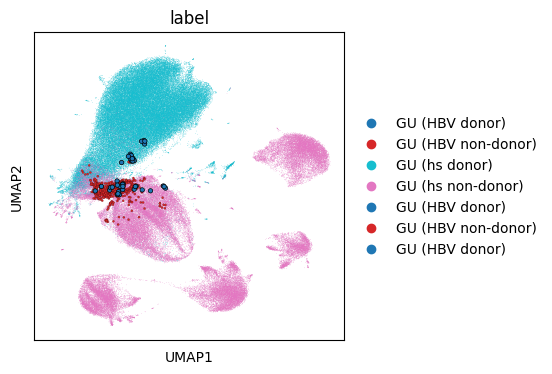

<Figure size 640x480 with 0 Axes>

In [2]:
splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_donor/consensus_splice_sites.SpliceBERT.L6.GT.res.h5ad")

fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(splicebert_ss, ax=ax, 
           color="label", size=0.5, show=False, palette=['#1f77b4', '#d62728', '#17becf', '#e377c2'])

sc.pl.umap(splicebert_ss[splicebert_ss.obs["label"].str.contains("HBV")], 
           size=10, show=False, ax=ax, edgecolor='black', linewidths=0.1, 
           color="label")

sc.pl.umap(splicebert_ss[splicebert_ss.obs["size"]==100], ax=ax, 
           color="label", size=40, edgecolor='black', linewidths=0.5)

plt.tight_layout()
fig.savefig("../results/figures/figs2/umap.donor.png", bbox_inches='tight', dpi=300)

In [3]:
lclus = splicebert_ss.obs[(splicebert_ss.obs.label.str.contains("HBV")) & (splicebert_ss.obs.label.str.contains("donor"))][["leiden_res_0.4"]].drop_duplicates()
dclus = pd.merge(splicebert_ss.obs.reset_index(), lclus).set_index("index")
dclus = splicebert_ss[dclus.index].copy()

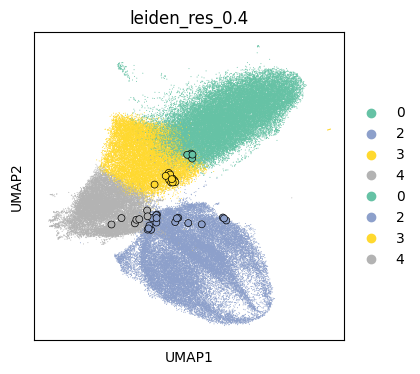

<Figure size 640x480 with 0 Axes>

In [4]:
fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(dclus, ax=ax, 
           color="leiden_res_0.4", size=2, show=False, palette="Set2")

sc.pl.umap(dclus[dclus.obs["size"]==100].copy(), ax=ax, 
           color="leiden_res_0.4", size=100, edgecolor='black', linewidths=0.5)

plt.tight_layout()
fig.savefig("../results/figures/figs2/umap.donors.leiden.png", bbox_inches='tight', dpi=300)

Calculate NMIs

In [5]:
donors = ['GU (donor)', 'GU (non-donor)']

cal_metric_by_group(splicebert_ss.obs["splice site"], splicebert_ss.obs["leiden_res_0.4"], donors=donors)

0.40460645195171296

In [6]:
donors = ['GU (hs donor)', 'GU (hs non-donor)']

cal_metric_by_group(dclus.obs["label"], dclus.obs["leiden_res_0.4"], donors=donors)

0.4726342969139182

In [7]:
donors = ['GU (HBV non-donor)', 'GU (HBV donor)']

cal_metric_by_group(dclus.obs["label"], dclus.obs["leiden_res_0.4"], donors=donors)

0.13277902552434523

Calculate percent true labels

In [8]:
crosstab_donors = pd.crosstab(index=dclus.obs["leiden_res_0.4"], columns=dclus.obs['splice site'])
crosstab_donors_perc = crosstab_donors.div(crosstab_donors.sum(axis=1), axis=0)

In [9]:
splice_vars = []

for i in lclus["leiden_res_0.4"].tolist():
    splice_var = ",".join(dclus.obs[(dclus.obs["leiden_res_0.4"]==i) & (dclus.obs.label.str.contains("HBV"))]["name2"].unique()).split(",")
    splice_var = list(set(splice_var))
    splice_vars.append([i, splice_var])
    
splice_vars = pd.DataFrame(splice_vars)
splice_vars.columns = ["leiden_res_0.4","HBV splice variants"]

crosstab_donors_perc = pd.merge(crosstab_donors_perc.reset_index(), splice_vars)
crosstab_donors_perc.to_pickle("../data/processed_files/crosstab_donors_perc.pkl.gz")
crosstab_donors_perc

,leiden_res_0.4,GU (donor),GU (non-donor),HBV splice variants
0,0,0.998566,0.001434,"[SP7, pSP12, pSP8, SP14, SP18]"
1,2,0.047875,0.952125,[none]
2,3,0.986607,0.013393,"[SP7, SP1, pSP11, SP11, SP9, pSP8, SP5, pSP7, ..."
3,4,0.603126,0.396874,"[SP5, none, SP4]"


Clustering splice acceptor sites

In [2]:
# Full Spliceator training set

splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_acceptor/consensus_splice_sites.SpliceBERT.L6.AG.h5ad")
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].apply(lambda x: ssdict[x])
splicebert_ss.obs["splice site"] = splicebert_ss.obs["name"].apply(lambda x: sslab[x])
splicebert_ss.obs["size"] = splicebert_ss.obs["name"].apply(lambda x: ssize[x])

# Re-run leiden with different resolutions
resolutions = [0.2, 0.4, 0.6, 0.8]

for res in resolutions:
    print(f"\nRunning leiden with resolution = {res}...")
    sc.tl.leiden(splicebert_ss, resolution=res, key_added=f'leiden_res_{res:.1f}', flavor="igraph", n_iterations=2, directed=False)
    print(f"Number of clusters for resolution {res}: {splicebert_ss.obs[f'leiden_res_{res:.1f}'].nunique()}")

# Fix splice sites that are caused by indels
splicebert_ss.obs["label"] = splicebert_ss.obs["label"].astype(str)
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3431-3433"), "label"] = "AG (HBV non-acceptor)"
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3431-3433"), "size"] = 10

splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3394-3396"), "label"] = "AG (HBV non-acceptor)"
splicebert_ss.obs.loc[splicebert_ss.obs.coordinate.str.contains(":3394-3396"), "size"] = 10

splicebert_ss.obs["label"] = splicebert_ss.obs["label"].astype("category")

splicebert_ss.write_h5ad("../data/processed_files/splicebert_acceptor/consensus_splice_sites.SpliceBERT.L6.AG.res.h5ad")


Running leiden with resolution = 0.2...
Number of clusters for resolution 0.2: 21

Running leiden with resolution = 0.4...
Number of clusters for resolution 0.4: 30

Running leiden with resolution = 0.6...
Number of clusters for resolution 0.6: 35

Running leiden with resolution = 0.8...
Number of clusters for resolution 0.8: 47


In [2]:
sns.color_palette("tab10").as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [3]:
print(sns.color_palette("tab10").as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


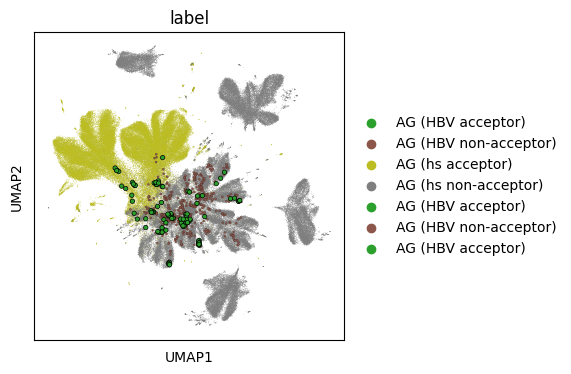

<Figure size 640x480 with 0 Axes>

In [11]:
splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_acceptor/consensus_splice_sites.SpliceBERT.L6.AG.res.h5ad")

fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(splicebert_ss, ax=ax, 
           color="label", size=0.5, show=False, palette=['#2ca02c', '#8c564b', '#bcbd22', '#7f7f7f'])

sc.pl.umap(splicebert_ss[splicebert_ss.obs["label"].str.contains("HBV")], 
           size=10, show=False, ax=ax, edgecolor='black', linewidths=0.1, 
           color="label")

sc.pl.umap(splicebert_ss[splicebert_ss.obs["size"]==100], ax=ax, 
           color="label", size=40, edgecolor='black', linewidths=0.5)

plt.tight_layout()
fig.savefig("../results/figures/figs2/umap.acceptor.png", bbox_inches='tight', dpi=300)

In [12]:
lclus = splicebert_ss.obs[(splicebert_ss.obs.label.str.contains("HBV")) & (splicebert_ss.obs.label.str.contains("acceptor"))][["leiden_res_0.4"]].drop_duplicates()
aclus = pd.merge(splicebert_ss.obs.reset_index(), lclus).set_index("index")
aclus = splicebert_ss[aclus.index].copy()

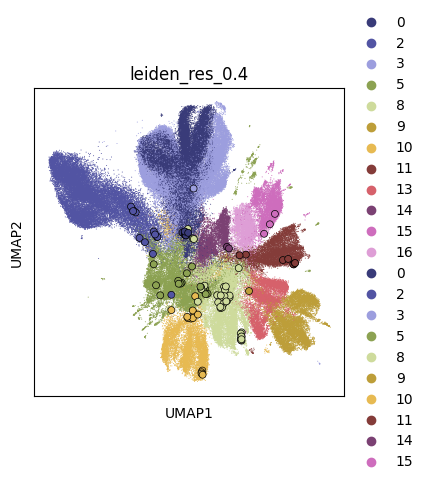

<Figure size 640x480 with 0 Axes>

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(aclus, ax=ax, 
           color="leiden_res_0.4", size=2, show=False, palette="tab20b")

sc.pl.umap(aclus[aclus.obs["size"]==100].copy(), ax=ax, 
           color="leiden_res_0.4", size=100, edgecolor='black', linewidths=0.5)

plt.tight_layout()
fig.savefig("../results/figures/figs2/umap.acceptor.leiden.png", bbox_inches='tight', dpi=300)

##### Calculcate acceptor NMI

In [14]:
acceptors = ['AG (acceptor)', 'AG (non-acceptor)']

cal_metric_by_group(splicebert_ss.obs["splice site"], splicebert_ss.obs["leiden_res_0.4"], acceptors=acceptors)

0.3238373359596899

In [15]:
acceptors = ['AG (hs acceptor)', 'AG (hs non-acceptor)']

cal_metric_by_group(aclus.obs["label"], aclus.obs["leiden_res_0.4"], acceptors=acceptors)

0.33093729111490455

In [16]:
acceptors = ['AG (HBV acceptor)', 'AG (HBV non-acceptor)']

cal_metric_by_group(aclus.obs["label"], aclus.obs["leiden_res_0.4"], acceptors=acceptors)

0.05494633546607122

Calculcate percent true labels

In [17]:
crosstab_acceptors = pd.crosstab(index=aclus.obs["leiden_res_0.4"], columns=aclus.obs['splice site'])
crosstab_acceptors_perc = crosstab_acceptors.div(crosstab_acceptors.sum(axis=1), axis=0)

In [18]:
splice_vars = []

for i in lclus["leiden_res_0.4"].tolist():
    splice_var = ",".join(aclus.obs[(aclus.obs["leiden_res_0.4"]==i) & (aclus.obs.label.str.contains("HBV"))]["name2"].unique()).split(",")
    splice_var = list(set(splice_var))
    splice_vars.append([i, splice_var])
    
splice_vars = pd.DataFrame(splice_vars)
splice_vars.columns = ["leiden_res_0.4","HBV splice variants"]

crosstab_acceptors_perc = pd.merge(crosstab_acceptors_perc.reset_index(), splice_vars)
crosstab_acceptors_perc.to_pickle("../data/processed_files/crosstab_acceptors_perc.pkl.gz")
crosstab_acceptors_perc

,leiden_res_0.4,AG (acceptor),AG (non-acceptor),HBV splice variants
0,0,0.975545,0.024455,[none]
1,2,0.992135,0.007865,"[SP7, SP1, pSP11, SP11, pSP12, SP9, pSP8, SP14..."
2,3,0.996419,0.003581,[none]
3,5,0.464928,0.535072,"[pSP10, none, pSP9]"
4,8,0.067687,0.932313,"[none, SP4]"
5,9,0.014802,0.985198,[none]
6,10,0.113551,0.886449,"[SP7, pSP8, SP18, SP13, none]"
7,11,0.055646,0.944354,"[none, pSP9]"
8,13,0.033486,0.966514,[none]
9,14,0.108547,0.891453,[none]


##### Compare percent typical splice sites with Leiden clusters

In [19]:
d = crosstab_donors_perc.explode("HBV splice variants")
d = d[d["HBV splice variants"].str.contains("SP")].copy().drop("GU (non-donor)", axis=1)
d.columns = ["leiden_donor","GU (donor)","HBV splice variants"]

a = crosstab_acceptors_perc.explode("HBV splice variants")
a = a[a["HBV splice variants"].str.contains("SP")].copy().drop("AG (non-acceptor)", axis=1)
a.columns = ["leiden_acceptor","AG (acceptor)","HBV splice variants"]

In [20]:
conss = pd.read_csv("../data/processed_files/consensus_splice_sites.bed.gz", sep="\t", header=None)
conss.columns = ["chrom","start","end","name","name2","strand"]
conss["coordinate"] = conss["chrom"] + ":" + conss["start"].astype(str) + "-" + conss["end"].astype(str)

dclus = dclus.obs.drop(["leiden_res_0.2","leiden_res_0.6","leiden_res_0.8"], axis=1).rename(columns = {"leiden_res_0.4":"leiden_res"})
aclus = aclus.obs.drop(["leiden_res_0.2","leiden_res_0.6","leiden_res_0.8"], axis=1).rename(columns = {"leiden_res_0.4":"leiden_res"})

conss = pd.merge(conss, pd.concat([dclus, aclus]))
conss.to_csv("../data/processed_files/conss.bed", sep="\t", index=None, header=None)

In [1]:
! bedtools intersect -a <(grep -v SRR ../data/processed_files/conss.bed) -b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wo -s \
    | bedtools intersect -a stdin -b ../ref/utr.hs.bed -v \
    | awk '!seen[$7]++' | cut -f10,12 | sort | uniq -c | sort -k2,2g \
    | awk '{print $4 "\t" $2,$3 "\t" $1}' > ../data/processed_files/conss.cds.stats

! bedtools intersect -a <(grep -v SRR ../data/processed_files/conss.bed) -b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wao -s \
    | bedtools intersect -a stdin -b ../ref/utr.hs.bed -v \
    | awk '!seen[$7]++' | cut -f10,12 | sort | uniq -c | sort -k2,2g \
    | awk '{print $4 "\t" $2,$3 "\t" $1}' > ../data/processed_files/conss.all.stats

In [2]:
import pandas as pd

conss_cds_stats = pd.read_csv("../data/processed_files/conss.cds.stats", sep="\t", header=None)
conss_cds_stats.columns = ["Leiden cluster","Splice site","Number of exonic splice sites"]
conss_all_stats = pd.read_csv("../data/processed_files/conss.all.stats", sep="\t", header=None)
conss_all_stats.columns = ["Leiden cluster","Splice site","Total number of splice sites"]

conss_stats = pd.merge(conss_cds_stats, conss_all_stats)
conss_stats["% Typical splice sites"] = 100-(conss_stats["Number of exonic splice sites"]/conss_stats["Total number of splice sites"]*100)

In [3]:
crosstab_donors_perc = pd.read_pickle("../data/processed_files/crosstab_donors_perc.pkl.gz")
crosstab_acceptors_perc = pd.read_pickle("../data/processed_files/crosstab_acceptors_perc.pkl.gz")

cdp = crosstab_donors_perc.reset_index()[["leiden_res_0.4","GU (donor)"]]
cdp["Splice site"] = "GU (donor)"
cdp.columns = ["Leiden cluster","% True label","Splice site"]
cap = crosstab_acceptors_perc.reset_index()[["leiden_res_0.4","AG (acceptor)"]]
cap["Splice site"] = "AG (acceptor)"
cap.columns = ["Leiden cluster","% True label","Splice site"]

In [4]:
crosstab_stats = pd.concat([cdp,cap])
crosstab_stats["Leiden cluster"] = crosstab_stats["Leiden cluster"].astype(int)
crosstab_stats["% True label"] = crosstab_stats["% True label"]*100

cstats = pd.merge(crosstab_stats, conss_stats)
cstats.to_pickle("../data/processed_files/cstats.pkl.gz")

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

cstats = pd.read_pickle("../data/processed_files/cstats.pkl.gz")
cstats["Splice site"] = cstats["Splice site"].str.replace("GU (donor)","Donor site").str.replace("AG (acceptor)","Acceptor site")

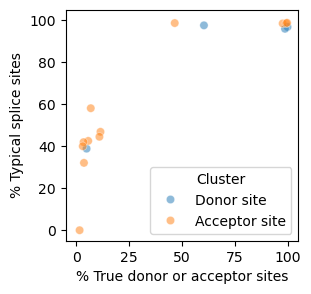

In [2]:
plt.figure(figsize=(3,3))

ax = sns.scatterplot(data=cstats, x="% True label", y="% Typical splice sites", 
            hue="Splice site", alpha=0.5)

plt.xlabel('% True donor or acceptor sites')
plt.ylabel('% Typical splice sites')
plt.legend(title="Cluster")
plt.xlim(-5,105)
plt.ylim(-5,105)
sns.move_legend(ax, "lower right")
plt.savefig("../results/figures/figs3/typical_splice_sites.png", bbox_inches='tight', dpi=300)

In [7]:
spearmanr(cstats["% Typical splice sites"], cstats["% True label"])

SignificanceResult(statistic=0.8764705882352942, pvalue=8.439118583861072e-06)

Map coSI scores to exonic CDS splice sites

In [ ]:
# building indexs for ipsa
! for i in A2 B2 C2 D3; do \
    sed "s/^HBV/${i}/" ../ref/pgrna/${i}/${i}.gtf > ../ref/ipsa_index/${i}.gtf && \
    cp ../ref/hbv/pgrna/${i}/${i}.pgrna.fa ../ref/ipsa_index; done
    
! cat ../ref/ipsa_index/*.gtf > ../ref/ipsa_index/hbv.gtf
! perl ../src/ipsa/Perl/transcript_elements.pl - < ../ref/ipsa_index/hbv.gtf > ../ref/ipsa_index/hbv.gfx
! ../src/ipsa/maptools-3.2/bin/transf -dir ./ -idx ../ref/ipsa_index/hbv.idx -dbx ../ref/ipsa_index/hbv.dbx 

# coSI
! REPO_DIR=`pwd | sed 's|jupyter_notebooks$||'` && \
  for i in ${REPO_DIR}/data/processed_files/*/*/Aligned.markdup.sorted.uniq.bam; do \
    cd $(dirname $i)/ && \
    ${REPO_DIR}/src/ipsa/sjcount-3.1/sjcount -bam Aligned.markdup.sorted.uniq.bam \
    -ssc ssc.1.tsv -log ssj.1.log -ssj ssj.1.tsv \
    -nbins 51 -read1 1 -quiet && \
    awk -f ${REPO_DIR}/src/ipsa/awk/aggregate.awk -v degree=0 -v readLength=51 -v margin=5 -v prefix= -v logfile=ssc.2.log ssc.1.tsv > ssc.2.tsv && \
    awk -f ${REPO_DIR}/src/ipsa/awk/aggregate.awk -v degree=1 -v readLength=51 -v margin=5 -v prefix= -v logfile=ssj.2.log ssj.1.tsv > ssj.2.tsv && \
    \
    cd ${REPO_DIR}/src/ipsa && \
    perl Perl/annotate.pl -deltaSS 10 \
    -annot ${REPO_DIR}/src/ipsa_index/hbv.gfx \
    -dbx ${REPO_DIR}/src/ipsa_index/hbv.dbx \
    -idx ${REPO_DIR}/src/ipsa_index/hbv.idx \
    -in $(dirname $i)/ssj.2.tsv \
    > $(dirname $i)/ssj.3.tsv && \
    \
    cd $(dirname $i)/ && \
    awk -f ${REPO_DIR}/src/ipsa/awk/choose_strand.awk ssj.3.tsv > ssj.4.tsv && \
    awk -f ${REPO_DIR}/src/ipsa/awk/constrain_ssc.awk -v jncfile=ssj.4.tsv ssc.2.tsv > ssc.4.tsv && \
    awk '$4>=1.5' ssc.4.tsv > ssc.6.tsv && \
    awk '$4>=1.5 && $5>=0' ssj.4.tsv > ssj.6.tsv && \
    \
    cd ${REPO_DIR}/src/ipsa && \
    perl Perl/zeta.pl \
    -annot ${REPO_DIR}/src/ipsa_index/hbv.gfx \
    -ssc $(dirname $i)/ssc.6.tsv \
    -ssj $(dirname $i)/ssj.6.tsv -mincount 10 \
    > $(dirname $i)/zeta.gff && \
    \
    cd $(dirname $i)/ && \
    awk 'BEGIN{OFS="\t"} $3~/exon/ {print $1,$4-1,$5,$10,".",$7}' zeta.gff | sed 's/[";]//g' > exon.zeta.bed && \
    awk 'BEGIN{OFS="\t"} $3~/intron/ {print $1,$4-1,$5,$10,$12,$7}' zeta.gff | sed 's/[";]//g' > intron.zeta.bed; done 2>&1 | tee ../data/processed_files/ipsa.log

Map coSI scores to exonic CDS splice sites

In [8]:
! cut -f-6,12 ../data/processed_files/conss.bed \
    | bedtools window -a stdin -b ../data/huh7/intron.zeta.pUC57.bed -l 1 -r 1 \
    | awk 'BEGIN{FS="\t"} (/hg19_donor/ && $6~/+/ && $2==($9+1)) || (/hg19_acceptor/ && $6~/+/ && $3==($10-1))' | cut -f-7,11,12 \
    | bedtools intersect -a stdin -b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wo -s \
    | awk '!seen[$1,$2,$3,$4,$5,$6,$7]++' > ../data/processed_files/exonicss.txt

! cat ../data/processed_files/intron.zeta.bed ../data/huh7/intron.zeta.bed | awk '!/NA/' \
    | datamash -g 1,2,3,6 -s median 4,5 \
    | awk 'BEGIN{OFS="\t"} {print $1,$2,$3,$5,$6,$4}' \
    | bedtools window \
    -a <(sed 's/_/\t/' ../data/processed_files/conss.bed | awk 'BEGIN{FS=OFS="\t"} /HBV/ {print $1,$3-255,$4-255,$5,$6,$7,$13}') \
    -b stdin -l 1 -r 1 | awk 'BEGIN{FS="\t"} ($6~/+/ && $2==($9+1)) || ($6~/+/ && $3==($10-1))'  | cut -f-7,11,12 \
    | awk '!seen[$1,$2,$3,$4,$5,$6,$7]++' > ../data/processed_files/exonicss.hbv.txt

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

exonicss = pd.read_csv("../data/processed_files/exonicss.txt", header=None, sep="\t")
exonicss = exonicss.rename(columns={6:"leiden_res_0.4",7:"coSI 3'",8:"coSI 5'"})
exonicss["transcriptome"] = "hs"

exonicss_hbv = pd.read_csv("../data/processed_files/exonicss.hbv.txt", header=None, sep="\t")
exonicss_hbv = exonicss_hbv.rename(columns={6:"leiden_res_0.4",7:"coSI 3'",8:"coSI 5'"})
exonicss_hbv["transcriptome"] = "HBV"

exonicss = pd.concat([exonicss, exonicss_hbv]).reset_index(drop=True)
exonicss.value_counts([3])

3                  
AG(hg19_acceptor)      2462
GT(hg19_donor)         2068
AG(C2_acceptor)           8
AG(B2_acceptor)           7
AG(D3_acceptor)           6
AG(B2_non-acceptor)       5
GT(B2_donor)              5
GT(C2_donor)              5
AG(A2_acceptor)           4
GT(A2_donor)              4
GT(D3_donor)              4
GT(B2_non-donor)          3
AG(C2_non-acceptor)       2
AG(D3_non-acceptor)       1
GT(D3_non-donor)          1
Name: count, dtype: int64

In [2]:
d = exonicss[exonicss[3].str.contains("donor")].copy()
d = pd.merge(d, d[d.transcriptome=="HBV"][["leiden_res_0.4"]].drop_duplicates())

a = exonicss[exonicss[3].str.contains("acceptor")].copy()
a = pd.merge(a, a[a.transcriptome=="HBV"][["leiden_res_0.4"]].drop_duplicates())

In [3]:
sns.color_palette("Set2").as_hex()

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3']

In [4]:
print(sns.color_palette("Set2").as_hex())

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


In [5]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_FLOOR, ROUND_CEILING

crosstab_donors_perc = pd.read_pickle("../data/processed_files/crosstab_donors_perc.pkl.gz")
crosstab_donors_perc["GU (donor)"] = crosstab_donors_perc["GU (donor)"].apply(lambda x: Decimal(str(x)).quantize(Decimal('0.10'), rounding=ROUND_HALF_UP))
crosstab_donors_perc["% Splice donor"] = crosstab_donors_perc["GU (donor)"].apply(lambda x: x*100).astype(int).astype(str)
crosstab_donors_perc["leiden_res_0.4"] = crosstab_donors_perc["leiden_res_0.4"].astype(int)
crosstab_donors_perc = pd.merge(crosstab_donors_perc, d[d.transcriptome=="HBV"][["leiden_res_0.4"]].drop_duplicates())

crosstab_acceptors_perc = pd.read_pickle("../data/processed_files/crosstab_acceptors_perc.pkl.gz")
crosstab_acceptors_perc["AG (acceptor)"] = crosstab_acceptors_perc["AG (acceptor)"].apply(lambda x: Decimal(str(x)).quantize(Decimal('0.10'), rounding=ROUND_HALF_UP))
crosstab_acceptors_perc["% Splice acceptor"] = crosstab_acceptors_perc["AG (acceptor)"].apply(lambda x: x*100).astype(int).astype(str)
crosstab_acceptors_perc["leiden_res_0.4"] = crosstab_acceptors_perc["leiden_res_0.4"].astype(int)
crosstab_acceptors_perc = pd.merge(crosstab_acceptors_perc, a[a.transcriptome=="HBV"][["leiden_res_0.4"]].drop_duplicates())

In [6]:
from scipy.stats import spearmanr

crosstab_donors_perc["leiden_res_0.4"] = crosstab_acceptors_perc["leiden_res_0.4"].astype(int)
dc = pd.merge(d[~d["coSI 5'"].isna()].groupby("leiden_res_0.4")["coSI 5'"].apply(np.median).reset_index(), crosstab_donors_perc.rename(columns={"GU (donor)":"proportion of splice site"}))

crosstab_acceptors_perc["leiden_res_0.4"] = crosstab_acceptors_perc["leiden_res_0.4"].astype(int)
ac = pd.merge(a[~a["coSI 3'"].isna()].groupby("leiden_res_0.4")["coSI 3'"].apply(np.median).reset_index(), crosstab_acceptors_perc.rename(columns={"AG (acceptor)":"proportion of splice site"}))

ssc = pd.concat([dc.rename(columns={"coSI 5'":"coSI"}), ac.rename(columns={"coSI 3'":"coSI"})])

spearmanr(ssc.coSI, ssc["proportion of splice site"])

SignificanceResult(statistic=0.9221179690936062, pvalue=1.977940249513343e-05)

In [6]:
# Create colour palette indices
dpsp1 = d[(d.transcriptome=="HBV") & (d[4].str.contains("none"))].copy()
dpsp2 = d[(d.transcriptome=="HBV") & (~d[4].str.contains(r"none|,SP|^SP"))].copy()
dpsp = pd.concat([dpsp1,dpsp2])

dsp = pd.concat([dpsp,d[(d.transcriptome=="HBV")]]).drop_duplicates(keep=False)
dsp_idx = dsp["leiden_res_0.4"].sort_values().unique()
dpsp_idx = dpsp["leiden_res_0.4"].sort_values().unique()
d_idx = np.unique(np.concatenate([dsp_idx, dpsp_idx])).tolist()

pal = ['#66c2a5','#8da0cb','#ffd92f','#b3b3b3']
pal_dict = dict(zip(d_idx, pal))

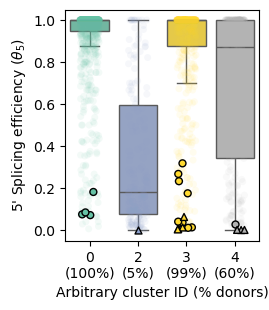

In [7]:
plt.figure(figsize=(2.5,3))

g = sns.boxplot(data=d, x="leiden_res_0.4", y="coSI 5'", hue="leiden_res_0.4", palette=pal, showfliers=False, legend=False)
g = sns.stripplot(data=d[d.transcriptome=="hs"], x="leiden_res_0.4", y="coSI 5'", hue="leiden_res_0.4", palette=pal,
                  alpha=0.08, jitter=0.2, legend=False)
g = sns.stripplot(data=dsp, x="leiden_res_0.4", y="coSI 5'", hue="leiden_res_0.4", palette=[pal_dict[i] for i in dsp_idx], 
                  edgecolor='black', linewidth=1, jitter=0.2, legend=False)
g = sns.stripplot(data=dpsp, x="leiden_res_0.4", y="coSI 5'", hue="leiden_res_0.4", palette=[pal_dict[i] for i in dpsp_idx], 
                  edgecolor='black', marker="^", linewidth=1, jitter=0.2, legend=False)
plt.xlabel("Arbitrary cluster ID (% donors)") # (splice donor sites)")#
plt.ylabel(r"5' Splicing efficiency ($\theta_5$)")

g.set_xticks(range(crosstab_donors_perc.shape[0]))
g.set_xticklabels(crosstab_donors_perc["leiden_res_0.4"].astype(str) + "\n(" + (crosstab_donors_perc["% Splice donor"].astype(str) + "%)"))

plt.savefig("../results/figures/figs3/cosi_donor.leiden.png", bbox_inches='tight',dpi=300)

In [8]:
apsp1 = a[(a.transcriptome=="HBV") & (a[4].str.contains("none"))].copy()
apsp2 = a[(a.transcriptome=="HBV") & (~a[4].str.contains(r"none|,SP|^SP"))].copy()
apsp = pd.concat([apsp1,apsp2])

asp = pd.concat([apsp,a[(a.transcriptome=="HBV")]]).drop_duplicates(keep=False)
asp_idx = asp["leiden_res_0.4"].sort_values().unique()
apsp_idx = apsp["leiden_res_0.4"].sort_values().unique()
a_idx = np.unique(np.concatenate([asp_idx, apsp_idx])).tolist()

pal =[ "#393b79","#5254a3","#9c9ede","#8ca252","#cedb9c","#e7ba52","#843c39","#7b4173","#ce6dbd"]
pal_dict = dict(zip(a_idx, pal))

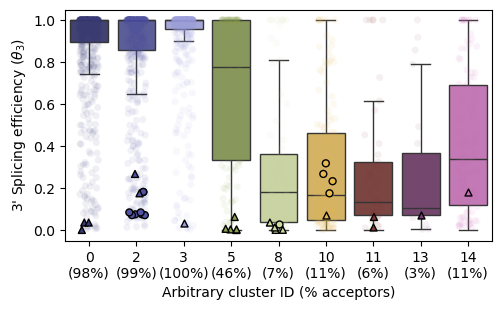

In [9]:
plt.figure(figsize=(5.5,3))

g = sns.boxplot(data=a, x="leiden_res_0.4", y="coSI 3'", hue="leiden_res_0.4", 
                palette=pal, showfliers=False, legend=False)
g = sns.stripplot(data=a[a.transcriptome=="hs"], x="leiden_res_0.4", y="coSI 3'", hue="leiden_res_0.4", 
                  palette=pal, alpha=0.08, jitter=0.2, legend=False)
g = sns.stripplot(data=asp, x="leiden_res_0.4", y="coSI 5'", hue="leiden_res_0.4", 
                  palette=[pal_dict[i] for i in asp_idx], edgecolor='black', linewidth=1, jitter=0.2, legend=False)
g = sns.stripplot(data=apsp, x="leiden_res_0.4", y="coSI 5'", hue="leiden_res_0.4", 
                  palette=[pal_dict[i] for i in apsp_idx], edgecolor='black', marker='^', linewidth=1, jitter=0.2, legend=False)

plt.xlabel("Arbitrary cluster ID (% acceptors)")
plt.ylabel(r"3' Splicing efficiency ($\theta_3$)")

g.set_xticks(range(crosstab_acceptors_perc.shape[0]))
g.set_xticklabels(crosstab_acceptors_perc["leiden_res_0.4"].astype(str) + "\n(" + (crosstab_acceptors_perc["% Splice acceptor"].astype(str) + "%)"))

plt.savefig("../results/figures/figs3/cosi_acceptor.leiden.png", bbox_inches='tight', dpi=300)

In [18]:
crosstab_donors_perc["HBV splice variants"] = crosstab_donors_perc["HBV splice variants"].apply(lambda x: ', '.join(sorted(x)))
crosstab_donors_perc["HBV splice variants"] = crosstab_donors_perc["HBV splice variants"].str.replace("none","other splice varints")
crosstab_donors_perc = crosstab_donors_perc[["leiden_res_0.4","% Splice donor","HBV splice variants"]]
crosstab_donors_perc.columns = ["Arbitrary cluster ID","% Splice donor","HBV splice variants"]
crosstab_donors_perc.to_csv("../data/processed_files/crosstab_donors_perc.csv", index=None)

In [19]:
crosstab_acceptors_perc["HBV splice variants"] = crosstab_acceptors_perc["HBV splice variants"].apply(lambda x: ', '.join(sorted(x)))
crosstab_acceptors_perc["HBV splice variants"] = crosstab_acceptors_perc["HBV splice variants"].str.replace("none","other splice varints")
crosstab_acceptors_perc = crosstab_acceptors_perc[["leiden_res_0.4","% Splice acceptor","HBV splice variants"]]
crosstab_acceptors_perc.columns = ["Arbitrary cluster ID","% Splice acceptor","HBV splice variants"]
crosstab_acceptors_perc.to_csv("../data/processed_files/crosstab_acceptors_perc.csv", index=None)

Calculate NMI for SP and others

In [2]:
splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_donor/consensus_splice_sites.SpliceBERT.L6.GT.res.h5ad")

lclus = splicebert_ss.obs[(splicebert_ss.obs.label.str.contains("HBV")) & (splicebert_ss.obs.label.str.contains("donor"))][["leiden_res_0.4"]].drop_duplicates()
dclus = pd.merge(splicebert_ss.obs.reset_index(), lclus).set_index("index")
dclus = splicebert_ss[dclus.index].copy()

dclus_psp1 = dclus.obs[(dclus.obs.name2.str.contains("none")) & (dclus.obs.label.str.contains("HBV donor"))]
dclus_psp2 = dclus.obs[(~dclus.obs.name2.str.contains(r"none|,SP|^SP")) & (dclus.obs.label.str.contains("HBV donor"))]
dclus_psp = pd.concat([dclus_psp1, dclus_psp2])
dclus_psp.shape

(27, 11)

In [3]:
dclus_sp = pd.concat([dclus.obs, dclus_psp]).drop_duplicates(keep=False)
dclus_psp = pd.concat([dclus_psp, 
                       dclus.obs[(dclus.obs.label.str.contains("HBV non-donor"))], 
                       dclus.obs[(dclus.obs.label.str.contains("hs"))]])

In [4]:
dclus.obs.shape, dclus_sp.shape, dclus_psp.shape

((97735, 11), (97708, 11), (97721, 11))

In [5]:
donors = ['GU (HBV non-donor)', 'GU (HBV donor)']

cal_metric_by_group(dclus_sp["label"], dclus_sp["leiden_res_0.4"], donors=donors)

0.1815269834695019

In [6]:
cal_metric_by_group(dclus_psp["label"], dclus_psp["leiden_res_0.4"], donors=donors)

0.04198741768907485

In [7]:
cal_metric_by_group(dclus.obs["label"], dclus.obs["leiden_res_0.4"], donors=donors)

0.13277902552434523

In [8]:
splicebert_ss = sc.read_h5ad("../data/processed_files/splicebert_acceptor/consensus_splice_sites.SpliceBERT.L6.AG.res.h5ad")

lclus = splicebert_ss.obs[(splicebert_ss.obs.label.str.contains("HBV")) & (splicebert_ss.obs.label.str.contains("acceptor"))][["leiden_res_0.4"]].drop_duplicates()
aclus = pd.merge(splicebert_ss.obs.reset_index(), lclus).set_index("index")
aclus = splicebert_ss[aclus.index].copy()

aclus_psp1 = aclus.obs[(aclus.obs.name2.str.contains("none")) & (aclus.obs.label.str.contains("HBV acceptor"))]
aclus_psp2 = aclus.obs[(~aclus.obs.name2.str.contains(r"none|,SP|^SP")) & (aclus.obs.label.str.contains("HBV acceptor"))]
aclus_psp = pd.concat([aclus_psp1, aclus_psp2])
aclus_psp.shape

(83, 11)

In [9]:
aclus_sp = pd.concat([aclus.obs, aclus_psp]).drop_duplicates(keep=False)
aclus_psp = pd.concat([aclus_psp, 
                       aclus.obs[(aclus.obs.label.str.contains("HBV non-acceptor"))], 
                       aclus.obs[(aclus.obs.label.str.contains("hs"))]])

In [10]:
aclus.obs.shape, aclus_sp.shape, aclus_psp.shape

((143348, 11), (143265, 11), (143335, 11))

In [11]:
acceptors = ['AG (HBV acceptor)', 'AG (HBV non-acceptor)']

cal_metric_by_group(aclus_sp["label"], aclus_sp["leiden_res_0.4"], acceptors=acceptors)

0.06991583572072976

In [12]:
cal_metric_by_group(aclus_psp["label"], aclus_psp["leiden_res_0.4"], acceptors=acceptors)

0.03450202766583055

In [13]:
cal_metric_by_group(aclus.obs["label"], aclus.obs["leiden_res_0.4"], acceptors=acceptors)

0.05494633546607122